In [1]:
# Importing Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve, roc_auc_score

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Loading the dataset
adultIncome_dataset = pd.read_csv('..\\..\\Datasets\\AdultIncome.csv')
print(adultIncome_dataset.shape, '\n')
adultIncome_dataset.head()

(43957, 15) 



,age,employment,fw,education,years-education,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,67,Private,366425,Doctorate,16,Divorced,Exec-managerial,Not-in-family,White,Male,99999,0,60,United-States,Yes
1,17,Private,244602,12th,8,Never-married,Other-service,Own-child,White,Male,0,0,15,United-States,No
2,31,Private,174201,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,40,United-States,Yes
3,58,State-gov,110199,7th-8th,4,Married-civ-spouse,Transport-moving,Husband,White,Male,0,0,40,United-States,No
4,25,State-gov,149248,Some-college,10,Never-married,Other-service,Not-in-family,Black,Male,0,0,40,United-States,No


In [3]:
# Printing basic statistics of the dataset
adultIncome_dataset.describe()

,age,fw,years-education,capital-gain,capital-loss,hours-per-week
count,43957.000000,4.395700e+04,43957.000000,43957.000000,43957.000000,43957.000000
mean,38.617149,1.896730e+05,10.074118,1093.559797,88.246491,40.407694
std,13.734401,1.058215e+05,2.575092,7570.536063,404.588410,12.400303
min,17.000000,1.349200e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.174960e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.781000e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.376710e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.490400e+06,16.000000,99999.000000,4356.000000,99.000000


In [4]:
# Printing info of the dataset
adultIncome_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43957 entries, 0 to 43956
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   age              43957 non-null  int64 
 1   employment       41459 non-null  object
 2   fw               43957 non-null  int64 
 3   education        43957 non-null  object
 4   years-education  43957 non-null  int64 
 5   marital-status   43957 non-null  object
 6   occupation       41451 non-null  object
 7   relationship     43957 non-null  object
 8   race             43957 non-null  object
 9   gender           43957 non-null  object
 10  capital-gain     43957 non-null  int64 
 11  capital-loss     43957 non-null  int64 
 12  hours-per-week   43957 non-null  int64 
 13  native-country   43957 non-null  object
 14  income           43957 non-null  object
dtypes: int64(6), object(9)
memory usage: 5.0+ MB


## Data Preprocessing

### 1. Handling Missing Values

In [5]:
# Checking for the missing values in the dataset
adultIncome_dataset.isnull().sum()

age                   0
employment         2498
fw                    0
education             0
years-education       0
marital-status        0
occupation         2506
relationship          0
race                  0
gender                0
capital-gain          0
capital-loss          0
hours-per-week        0
native-country        0
income                0
dtype: int64

In [6]:
# Since both the 'employment' and 'occupation' are categorical non-numerical, we will use mode value to impute the missing values.
adultIncome_dataset.fillna({'employment':adultIncome_dataset['employment'].mode()[0]}, inplace=True)
adultIncome_dataset.fillna({'occupation':adultIncome_dataset['occupation'].mode()[0]}, inplace=True)

In [7]:
# Checking the missing values after imputing
print('Missing Values in the Dataset:', adultIncome_dataset.isnull().sum().sum())

Missing Values in the Dataset: 0


<br>
<h3> 2. Scaling Numerical Features </h3>

In [8]:
# Selecting the Numerical Features to be scaled
numerical_features = adultIncome_dataset[['age', 'fw', 'capital-gain', 'capital-loss']]   # Since 'years-education' and 'hours-per-week' are ordinal in nature.

# Standardizing the features
scaler = StandardScaler()

for feature in numerical_features.columns:
    adultIncome_dataset[feature] = scaler.fit_transform(adultIncome_dataset[[feature]])

In [9]:
# Checking mean and std of scaled features
adultIncome_dataset[['age', 'fw', 'capital-gain', 'capital-loss']].describe().round(2)

,age,fw,capital-gain,capital-loss
count,43957.00,43957.00,43957.00,43957.00
mean,0.00,-0.00,-0.00,-0.00
std,1.00,1.00,1.00,1.00
min,-1.57,-1.66,-0.14,-0.22
25%,-0.77,-0.68,-0.14,-0.22
50%,-0.12,-0.11,-0.14,-0.22
75%,0.68,0.45,-0.14,-0.22
max,3.74,12.29,13.06,10.55


<br>
<h3> 3. Encoding Categorical Features </h3>

In [10]:
# Selecting the categorical features from the dataset
categorical_features = adultIncome_dataset.select_dtypes('object').columns
categorical_features

Index(['employment', 'education', 'marital-status', 'occupation',
       'relationship', 'race', 'gender', 'native-country', 'income'],
      dtype='object')

In [11]:
# Encoding categorical features through Label Encoder
encoder = LabelEncoder()

for feature in categorical_features:
    adultIncome_dataset[feature] = encoder.fit_transform(adultIncome_dataset[feature])

In [12]:
# Checking categories and datatypes of categorical features after encoding
for feature in categorical_features:
    print(feature, ': ', adultIncome_dataset[feature].nunique(), ': ', adultIncome_dataset[feature].unique(), ': ', adultIncome_dataset[feature].dtype)

employment :  8 :  [3 6 5 0 1 4 2 7] :  int64
education :  16 :  [10  2  9  5 15 11  6  0  1 12 13  4 14  8  3  7] :  int64
marital-status :  7 :  [0 4 2 6 5 3 1] :  int64
occupation :  14 :  [ 3  7 13  0  6 11  5  4 10  9  2 12  8  1] :  int64
relationship :  6 :  [1 3 0 5 4 2] :  int64
race :  5 :  [4 2 1 3 0] :  int64
gender :  2 :  [1 0] :  int64
native-country :  42 :  [38 23 34 31 21 25  6  8 29  2 10 39  5 22 40 36 32  4 18  0 41 19  7 30
 11 20  1 12 33  3 27 13 28 26 35  9 37 24 17 15 16 14] :  int64
income :  2 :  [1 0] :  int64


<br>
<h3> 4. Balancing Imbalanced Data </h3>

income
0    33439
1    10518
Name: count, dtype: int64 




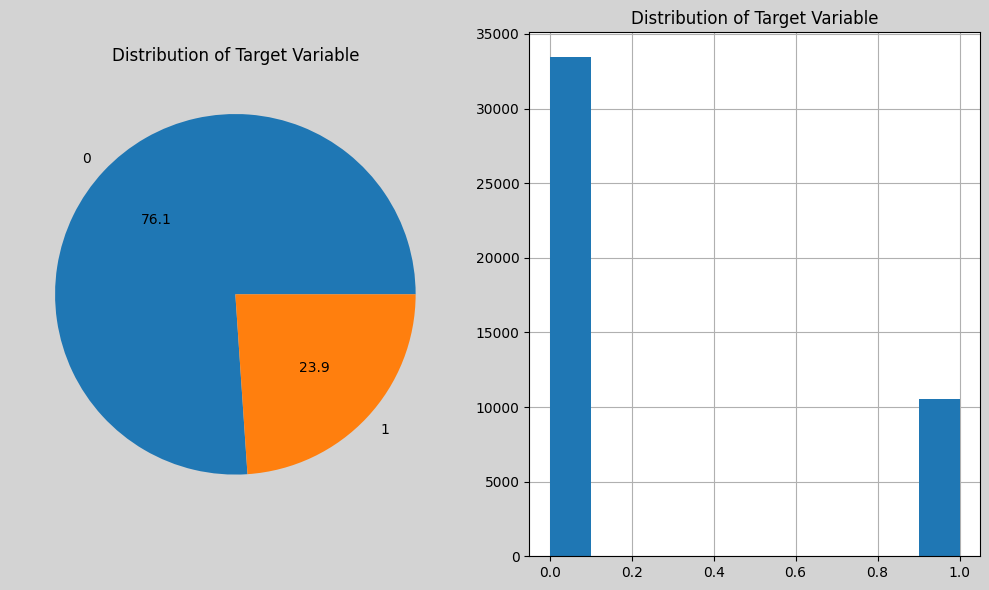

In [13]:
# Checking if the target variable is imbalanced
print(adultIncome_dataset['income'].value_counts(), '\n\n')

# Visualizing this distribution using pie chart and histogram chart
plt.figure(figsize=(10, 6), facecolor='lightgray')

plt.subplot(1, 2, 1)
plt.pie(adultIncome_dataset['income'].value_counts(), labels=adultIncome_dataset['income'].value_counts().index, autopct='%.1f')
plt.title('Distribution of Target Variable')

plt.subplot(1, 2, 2)
plt.hist(adultIncome_dataset['income'], zorder=2)
plt.title('Distribution of Target Variable')
plt.grid(True, zorder=1)

plt.tight_layout()
plt.show()

In [14]:
# The target variable is much imbalanced. We will resample it using SMOTE technique.
smote = SMOTE()

# Separating the features and target variable
X = adultIncome_dataset.drop('income', axis=1)
Y = adultIncome_dataset['income']

# Applying SMOTE over sampling on the target variable
X, Y = smote.fit_resample(X, Y)

income
1    33439
0    33439
Name: count, dtype: int64 




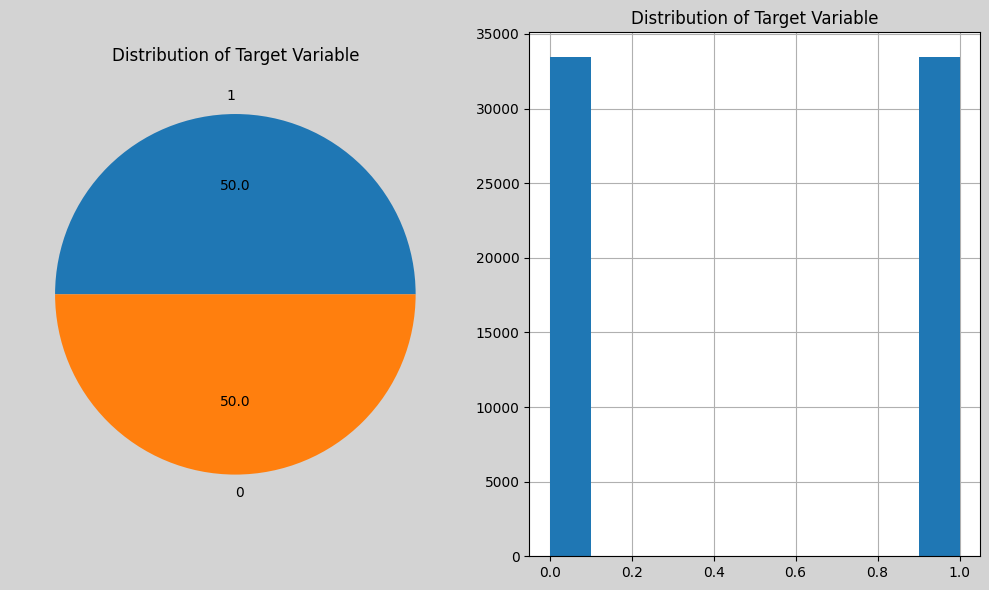

In [15]:
# Checking target variable after balancing
print(Y.value_counts(), '\n\n')

# Visualizing this distribution using pie chart and histogram chart after balancing
plt.figure(figsize=(10, 6), facecolor='lightgray')

plt.subplot(1, 2, 1)
plt.pie(Y.value_counts(), labels=Y.value_counts().index, autopct='%.1f')
plt.title('Distribution of Target Variable')

plt.subplot(1, 2, 2)
plt.hist(Y, zorder=2)
plt.title('Distribution of Target Variable')
plt.grid(True, zorder=1)

plt.tight_layout()
plt.show()

<br>
<h3> 5. Handling Outliers for the Numerical Features </h3>

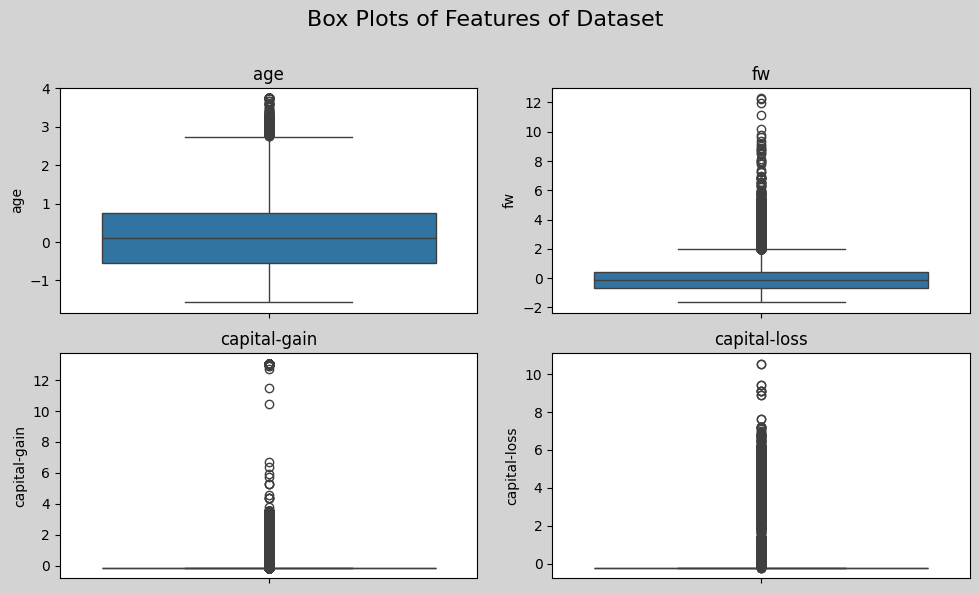

In [16]:
# Plotting the box plot to visualize the outliers in numerical features
# Set up the matplotlib figure
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 6), facecolor='lightgray')
fig.suptitle('Box Plots of Features of Dataset', fontsize=16)

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Plot box plots for each feature
for i, column in enumerate(X[['age', 'fw', 'capital-gain', 'capital-loss']].columns):
    sns.boxplot(y=X[column], ax=axes[i])
    axes[i].set_title(column)

# Remove any empty subplots
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

# Adjust layout
plt.tight_layout()
plt.subplots_adjust(top=0.85)
plt.show()


In [17]:
# Since the numerical features have many outliers, I will prefer using IQR method to cap these outliers.
# Computing the IQR
Q1 = X[['age', 'fw', 'capital-gain', 'capital-loss']].quantile(0.25)
Q3 = X[['age', 'fw', 'capital-gain', 'capital-loss']].quantile(0.75)
IQR = Q3 - Q1

# Finding upper limit and lower limit
upper_limit = Q3 + 1.5*IQR
lower_limit = Q1 - 1.5*IQR

print('IQR:', IQR, '\n')
print('Upper Limit:', upper_limit, '\n')
print('Lower Limit:', lower_limit, '\n')

IQR: age             1.310593
fw              1.058381
capital-gain    0.000000
capital-loss    0.000000
dtype: float64 

Upper Limit: age             2.721872
fw              1.999959
capital-gain   -0.144451
capital-loss   -0.218117
dtype: float64 

Lower Limit: age            -2.520499
fw             -2.233564
capital-gain   -0.144451
capital-loss   -0.218117
dtype: float64 



In [18]:
# Capping the outliers
for column in X[['age', 'fw', 'capital-gain', 'capital-loss']].columns:
    X[column] = np.where(
        X[column] > upper_limit[column],                   # Condition 1
        upper_limit[column],                               # If condition 1 is true
        np.where(                                          # If condition 1 is false
            X[column] < lower_limit[column],               # Condition 2
            lower_limit[column],                           # If condition 2 is true
            X[column]                                      # If condition 2 is false
        )
    )

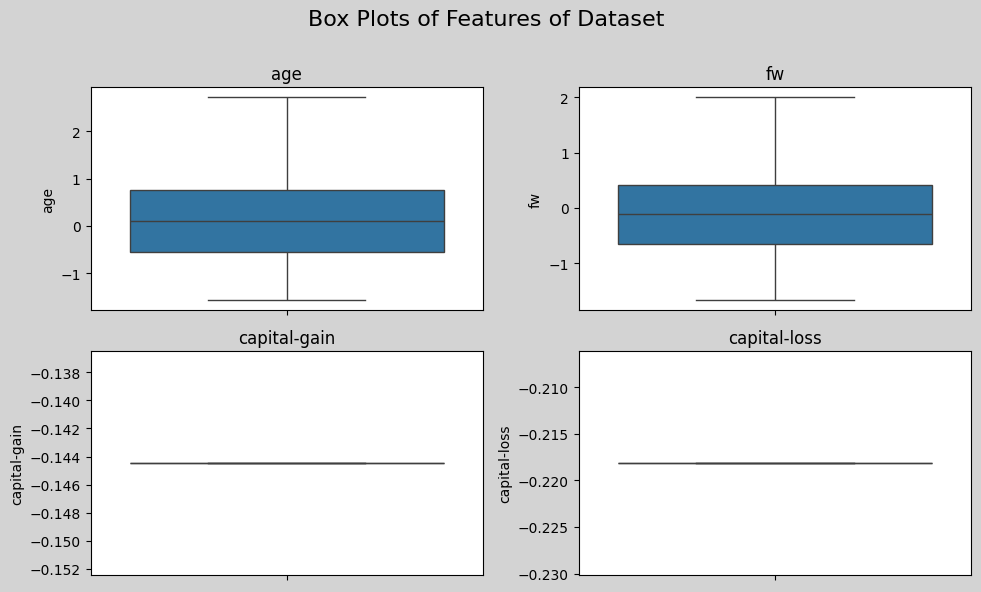

In [19]:
# Plotting the box plot to visualize the outliers in numerical features after capping
# Set up the matplotlib figure
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 6), facecolor='lightgray')
fig.suptitle('Box Plots of Features of Dataset', fontsize=16)

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Plot box plots for each feature
for i, column in enumerate(X[['age', 'fw', 'capital-gain', 'capital-loss']].columns):
    sns.boxplot(y=X[column], ax=axes[i])
    axes[i].set_title(column)

# Remove any empty subplots
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

# Adjust layout
plt.tight_layout()
plt.subplots_adjust(top=0.85)
plt.show()


-> Now, the dataset has been preprocessed and is ready to for model training.

In [20]:
# Splitting the dataste using single train test split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

<br><hr><br>
<h1>1. Applying Cross-Validation to Random Forest Classifier</h1>
<h3><b>Exercise:</b> Implement a random forest classifier and evaluate the model using k-fold cross-validation. <br>
Analyze the cross-validation scores to assess model stability. </h3>

In [21]:
# Implementing Random Forest Classifier model
rfc_model = RandomForestClassifier()

# Calculating cross validation scores
cv_scores = cross_val_score(rfc_model, X, Y, cv=10)

In [22]:
# Evaluating the model using cross validation scores
print('Cross Validation Scores:', cv_scores)
print(f'Mean score: {cv_scores.mean() : .4f}')
print(f'Standard Deviation: {cv_scores.std() : .4f}')

Cross Validation Scores: [0.8243122  0.82625598 0.8298445  0.8889055  0.89772727 0.90251196
 0.90086722 0.89608254 0.8971138  0.90010468]
Mean score:  0.8764
Standard Deviation:  0.0327


-> The mean cross-validation score of 0.8740 indicates that the Random Forest Classifier is performing well on average, achieving an accuracy of approximately 87.40% across the 10 different folds. <br><br>
-> The standard deviation of 0.0325 is relatively low, suggesting that the model’s performance is consistent across the different subsets of the data. <br><br>
-> The scores range from 0.8210 to 0.8995, indicating that while there is some variability in performance, the fluctuations are not drastic. This consistency is a good sign of model stability. So overall, model performance is good and it is stable.

<hr>

<br>
<h1>2. Investigating Overfitting and Underfitting in Gradient Boosting Machines</h1>
<h3><b>Exercise:</b> Train a gradient boosting classifier with varying numbers of estimators and learning rates. <br>
Evaluate the model for overfitting and underfitting by comparing training and validation performance.</h3>

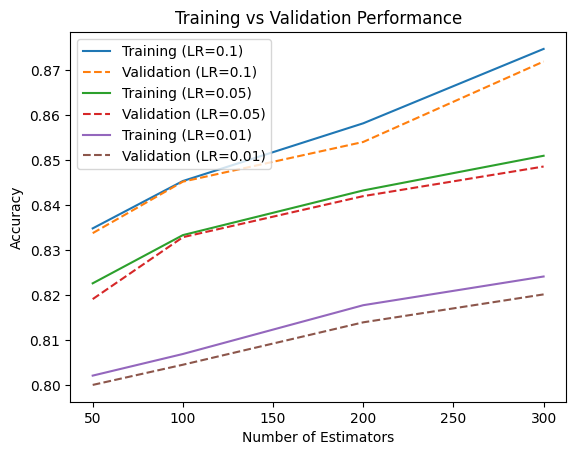

In [23]:
n_estimators = [50, 100, 200, 300]
learning_rates = [0.1, 0.05, 0.01]

train_results = {}
val_results = {}

for lr in learning_rates:
    train_accuracies = []
    val_accuracies = []
    for n in n_estimators:
        gbc_model = GradientBoostingClassifier(n_estimators=n, learning_rate=lr, random_state=42)
        gbc_model.fit(X_train, Y_train)

        # Training performance
        train_acc = gbc_model.score(X_train, Y_train)
        train_accuracies.append(train_acc)
        
        # Validation performance
        val_acc = gbc_model.score(X_test, Y_test)
        val_accuracies.append(val_acc)
    
    train_results[lr] = train_accuracies
    val_results[lr] = val_accuracies

    plt.plot(n_estimators, train_accuracies, label=f'Training (LR={lr})')
    plt.plot(n_estimators, val_accuracies, label=f'Validation (LR={lr})', linestyle='--')

plt.xlabel('Number of Estimators')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training vs Validation Performance')
plt.show()

-> From the graph, it can be seen that the model tends to underfit for low learning rate (lr=0.01) since both the training and validation scores are relatively low and the model is tends to overfit at high learning rate (lr=0.1) since the training and the validation curves are moving away from each other. 

<li><b>High Learning Rate (LR=0.1):</b> <br><u>Training Accuracy:</u> Continues to increase significantly with the number of estimators. <br> <u>Validation Accuracy:</u> Increases initially but starts to plateau around 150 estimators. Beyond this point, the gap between training and validation accuracy widens, indicating the onset of overfitting. The model performs well on the training data but not as well on the validation data.</li>
<br>
<li><b>Moderate Learning Rate (LR=0.05):</b> <br><u>Training Accuracy:</u> Increases steadily but at a slower rate than with LR=0.1. <br> <u>Validation Accuracy:</u> Also increases but plateaus around 200 estimators. The gap between training and validation accuracy is smaller than for LR=0.1, suggesting less overfitting but still some degree of it.</li> 
<br>
<li><b>Low Learning Rate (LR=0.01):</b> <br><u>Training Accuracy:</u> Increases more slowly compared to higher learning rates, indicating that the model is learning more slowly. <br> <u>Validation Accuracy:</u> Also increases steadily with a very small gap between training and validation accuracy. This suggests that the model is less prone to overfitting, but it might still be underfitting since both accuracies are relatively low.</li> 

<hr>

<br>
<h1>3. Evaluating Precision, Recall, and F1-Score for Random Forests</h1>
<h3><b>Exercise:</b> Implement a random forest classifier and calculate precision, recall, and F1-score. <br>
Discuss the trade-offs between these metrics and their importance for classification tasks.</h3>

In [24]:
# Implementing a Random Forest Classifier
rfc_model = RandomForestClassifier()
rfc_model.fit(X_train, Y_train)

# Predicting the target variable
Y_pred = rfc_model.predict(X_test)

In [25]:
# Calculating Precision score
print(f'Precision score of the model: {precision_score(Y_test, Y_pred): .4f}')

# Calculating Recall score
print(f'Recall score of the model: {recall_score(Y_test, Y_pred): .4f}')

# Calculating F1 score
print(f'F1 score of the model: {f1_score(Y_test, Y_pred): .4f}')

Precision score of the model:  0.8621
Recall score of the model:  0.8962
F1 score of the model:  0.8788


- <b>Precision: </b>Precision measures the proportion of true positives among all predicted positives. The model's precision score of 0.8586 indicates that 85.86% of the positive predictions are correct, meaning it has a low false positive rate.
- <b>Recall: </b>Recall measures the proportion of true positives among all actual positives. With a recall score of 0.8919, the model successfully identifies 89.19% of the actual positives, showing it effectively captures most of the true positives.
- <b>F1: </b>The F1-score is the harmonic mean of precision and recall, providing a single metric that balances both. The F1-score of 0.8749 balances the precision and recall, suggesting a well-rounded performance where both false positives and false negatives are reasonably minimized.
<br>

#### <b>Trade-Offs</b> <br>
- <b>Precision vs. Recall:</b> Increasing precision often reduces recall and vice versa. Depending on your specific problem, you may prioritize one over the other. For instance, in spam detection, you might prioritize recall to avoid missing any spam emails, even if it means some legitimate emails are incorrectly flagged as spam.
- <b>F1-Score:</b> The F1-score balances the trade-off between precision and recall, offering a more holistic view of model performance. If both precision and recall are equally important for your task, the F1-score is a good metric to focus on.


<hr>

<br>
<h1>4. ROC Curve and AUC for Gradient Boosting Classifier</h1>
<h3><b>Exercise:</b> Implement a gradient boosting classifier and plot the ROC curve.<br>
Compute the AUC and interpret how well the model distinguishes between classes.</h3>

In [26]:
# Implementing Gradient Boosting Classifier model 
gbc_model = GradientBoostingClassifier()
gbc_model.fit(X_train, Y_train)

# Predicting the probabilities to compute the ROC curve
Y_pred_proba = gbc_model.predict_proba(X_test)[:, 1]

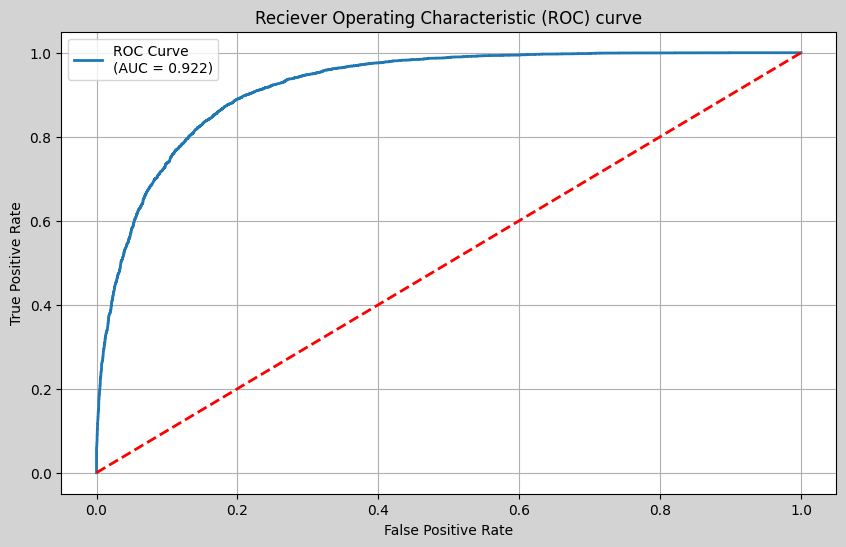

In [27]:
# Computing fpr, tpr and thresholds for ROC curve
fpr, tpr, thresholds = roc_curve(Y_test, Y_pred_proba)

# Computing the AUC score
auc = roc_auc_score(Y_test, Y_pred_proba)

# Plotting the ROC curve
plt.figure(figsize=(10, 6), facecolor='lightgray')
plt.plot(fpr, tpr, lw=2, label=f'ROC Curve\n(AUC = {auc:.3f})')   # The ROC curve with fpr on x-axis and tpr on y-axis
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')   # The reference 0.5 AUC line.
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Reciever Operating Characteristic (ROC) curve')
plt.legend()
plt.grid(True, zorder=1)
plt.show()

In [28]:
# Printing the AUC of ROC curve
print(f'The Area under ROC curve: {auc: .3f}')

The Area under ROC curve:  0.922


-> The AUC value of 0.919 suggests that the model correctly guesses 91.9% of the predictions. The ROC curve is also well above the line of random guessing model (red dashed line) indicating the model performance is extremely well.
<br><br>
-> The point where the ROC curve is close to the y-axis and far from the x-axis (closest to the top-left corner) indicates that this threshold is best for this classification problem, since the TPR is higher than the FPR.

<hr>

<br>
<h1>5. Model Performance Comparison with Different Metrics</h1>
<h3><b>Exercise:</b> Compare the performance of different classifiers (e.g., SVM, random forest, gradient boosting) using cross-validation. <br>
Evaluate and compare the models based on accuracy, precision, recall, F1-score, and ROC-AUC.</h3>

In [29]:
def evaluate_model(model, X, Y):
    # Calculating cross validation scores
    cv_accuracy = cross_val_score(model, X, Y, cv=10, scoring='accuracy')
    cv_precision = cross_val_score(model, X, Y, cv=10, scoring='precision')
    cv_recall = cross_val_score(model, X, Y, cv=10, scoring='recall')
    cv_f1 = cross_val_score(model, X, Y, cv=10, scoring='f1')
    cv_roc_auc = cross_val_score(model, X, Y, cv=10, scoring='roc_auc')

    # Printing the evaluation metrics
    print('Cross Validation Scores:', '\n')
    print(f'Mean Accuracy: {cv_accuracy.mean(): .4f}')
    print(f'Mean Precision: {cv_precision.mean(): .4f}')
    print(f'Mean Recall: {cv_recall.mean(): .4f}')
    print(f'Mean F1 Score: {cv_f1.mean(): .4f}')
    print(f'Mean ROC AUC Score: {cv_roc_auc.mean(): .4f}')

In [30]:
# Initializing Random Forest Classifier
rfc_model = RandomForestClassifier()
evaluate_model(rfc_model, X, Y)

Cross Validation Scores: 

Mean Accuracy:  0.8753
Mean Precision:  0.8575
Mean Recall:  0.9023
Mean F1 Score:  0.8781
Mean ROC AUC Score:  0.9444


In [31]:
# Initialzing Gradient Boosting Machines
gbc_model = GradientBoostingClassifier()
evaluate_model(gbc_model, X, Y)

Cross Validation Scores: 

Mean Accuracy:  0.8407
Mean Precision:  0.8156
Mean Recall:  0.8801
Mean F1 Score:  0.8460
Mean ROC AUC Score:  0.9200


In [32]:
# Initializing Logistic Regressing 
lr_model = LogisticRegression()
evaluate_model(lr_model, X, Y)

Cross Validation Scores: 

Mean Accuracy:  0.7486
Mean Precision:  0.7350
Mean Recall:  0.7778
Mean F1 Score:  0.7558
Mean ROC AUC Score:  0.8256


#### <b>Comparison</b>
- <b>Random Forest</b> outperforms both <b>Gradient Boosting</b> and <b>Logistic Regression</b> across all metrics. It shows the highest accuracy, precision, recall, F1 score, and ROC AUC score.
<br><br>
- <b>Gradient Boosting</b> follow, with strong performance but slightly lower scores compared to <b>Random Forest</b>.
<br><br>
- <b>Logistic Regression</b> shows the lowest performance among the three, particularly in terms of accuracy, precision, recall, and ROC AUC score.

<hr>